<div style="border: 2px solid #2196F3; border-radius: 8px; padding: 15px; background-color: rgba(33, 150, 243, 0.3); color: white;">
    <h3 style="color: white;">OBJECTIF</h3>
    <p>
        PRÉDIRE SI UNE TUMEUR EST MALIGNE OU BÉNIGNE À PARTIR DE MESURES CLINIQUES
    </p>
</div>

# Setup

In [91]:
#%pip install -r ../requirements.txt

In [92]:
# Manipulation et visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Préparation des données
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Modèles de classification utilisés
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Évaluation des modèles
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, make_scorer

# Sauvegarde éventuelle du modèle
import pickle

In [93]:
# Import du dataset
df = pd.read_csv("../data/raw/data.csv")

In [94]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [95]:
# Encodage de la variable cible 
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

In [96]:
df.drop(columns=["id", "Unnamed: 32"], inplace=True, errors='ignore')

# EDA

In [97]:
import dtale
dtale.show(df)

In [98]:
# Distribution de la cible’
df["diagnosis"].value_counts(normalize=True)

0    0.627417
1    0.372583
Name: diagnosis, dtype: float64

<div style="border: 1px solid #888888; border-radius: 5px; padding: 8px 12px; background-color: rgba(200, 200, 200, 0.15); color: white; display: inline-block; font-size: 90%;">
    <strong>Remarque</strong> : le dataset reste relativement équilibré pour une tâche de classification.
</div>


In [99]:
# Affichage des colonnes fortement corrélées (>0.9)
corr_matrix = df.drop(columns="diagnosis").corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_vars = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
print(high_corr_vars)

['perimeter_mean', 'area_mean', 'concave points_mean', 'perimeter_se', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'concave points_worst']


<div style="border: 1px solid #888888; border-radius: 5px; padding: 8px 12px; background-color: rgba(200, 200, 200, 0.15); color: white; display: inline-block; font-size: 90%;">
    <strong>Remarque</strong> : ces 10 variables devront éventuellement être enlevées en fonction du modèle que l'on va utiliser.
</div>


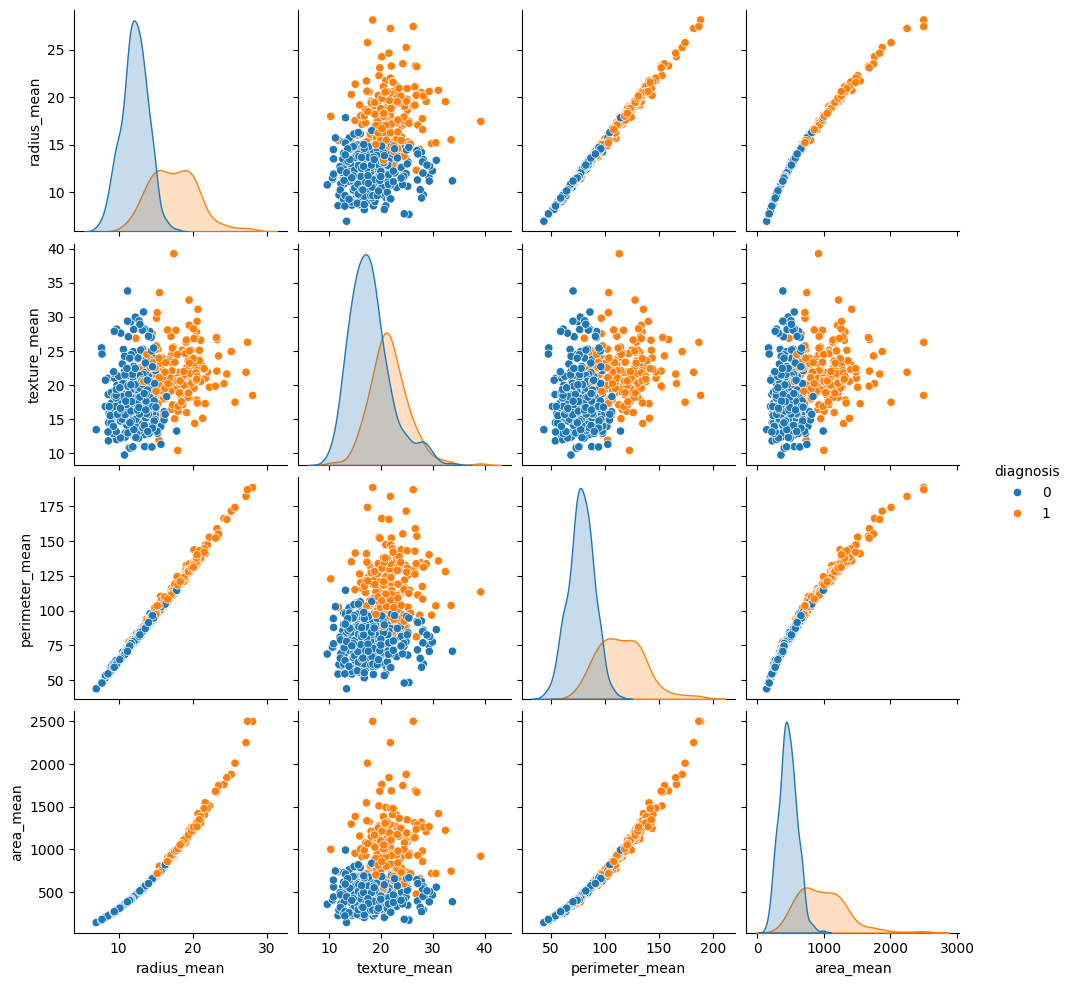

In [100]:
sns.pairplot(df[["radius_mean", "texture_mean", "perimeter_mean", "area_mean", "diagnosis"]], hue="diagnosis")

<div style="border: 1px solid #888888; border-radius: 5px; padding: 8px 12px; background-color: rgba(200, 200, 200, 0.15); color: white; display: inline-block; font-size: 90%;">
    <strong>Remarque</strong> : le pairplot met en évidence une nette séparation entre les tumeurs bénignes et malignes sur plusieurs variables clés, notamment <code>radius_mean</code>, <code>perimeter_mean</code> et <code>area_mean</code>, où les observations malignes présentent systématiquement des valeurs plus élevées. À l’inverse, la variable <code>texture_mean</code> semble moins discriminante visuellement, avec une distribution plus homogène entre les deux classes.
</div>


# Data Préparation

In [101]:
X = df.drop(columns=["diagnosis"]) 
y = df["diagnosis"]

In [102]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [103]:
# Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<div style="border: 1px solid #888888; border-radius: 5px; padding: 8px 12px; background-color: rgba(200, 200, 200, 0.15); color: white; display: inline-block; font-size: 90%;">
    <strong>Remarque</strong> : on standardise les données car <code>SVM</code> et la régression logistique sont sensibles à l’échelle des variables.
</div>


# Modélisation

In [104]:
# Gestion des colonnes à exclure pour la régression logistique
cols_to_drop = ['perimeter_mean', 'area_mean', 'concave points_mean',
                'perimeter_se', 'area_se', 'radius_worst', 'texture_worst',
                'perimeter_worst', 'area_worst', 'concave points_worst']

X_train_log = X_train.drop(columns=cols_to_drop)
X_test_log = X_test.drop(columns=cols_to_drop)

In [105]:
# Configuration des modèles
model_configs = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=10000, solver='saga', class_weight='balanced'),
        "params": {
            "C": [0.1, 1, 10],
            "solver": ["saga"]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, class_weight='balanced'),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 5, 10]
        }
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42, class_weight='balanced'),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale"]
        }
    }
}

In [106]:
f1_custom = make_scorer(f1_score, pos_label=1)

In [107]:
# Entraînement, GridSearchCV et évaluation
results = []

for name, config in model_configs.items():
    print(f"\n===== Modèle : {name} =====")
    grid = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        cv=5,
        scoring=f1_custom,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    print("Matrice de confusion :")
    print(confusion_matrix(y_test, y_pred))
    print("\nRapport de classification :")
    print(classification_report(y_test, y_pred, digits=3))

    results.append({
        "Model": name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 3),
        "Precision": round(precision_score(y_test, y_pred), 3),
        "Recall": round(recall_score(y_test, y_pred), 3),
        "F1 Score": round(f1_score(y_test, y_pred), 3)
    })


===== Modèle : Logistic Regression =====
Matrice de confusion :
[[71  1]
 [ 8 34]]

Rapport de classification :
              precision    recall  f1-score   support

           0      0.899     0.986     0.940        72
           1      0.971     0.810     0.883        42

    accuracy                          0.921       114
   macro avg      0.935     0.898     0.912       114
weighted avg      0.926     0.921     0.919       114


===== Modèle : Random Forest =====
Matrice de confusion :
[[72  0]
 [ 4 38]]

Rapport de classification :
              precision    recall  f1-score   support

           0      0.947     1.000     0.973        72
           1      1.000     0.905     0.950        42

    accuracy                          0.965       114
   macro avg      0.974     0.952     0.961       114
weighted avg      0.967     0.965     0.965       114


===== Modèle : SVM =====
Matrice de confusion :
[[70  2]
 [ 6 36]]

Rapport de classification :
              precision    re

In [108]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1 Score", ascending=False)
results_df

,Model,Accuracy,Precision,Recall,F1 Score
1,Random Forest,0.965,1.000,0.905,0.950
2,SVM,0.930,0.947,0.857,0.900
0,Logistic Regression,0.921,0.971,0.810,0.883


In [109]:
# Sauvegarder le meilleur modèle global
best_model_name = results_df.iloc[0]["Model"]
final_model = model_configs[best_model_name]["model"]
final_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [110]:
import os
import pickle
os.makedirs("../modele", exist_ok=True)

In [111]:
with open("../modele/best_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

with open("../modele/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)